# Looking at broader patterns in IGA-seq

Fig 5. IGA-labelled bacteria include the IBD-associated bacterium Ruminococcus gnavus and . (a) Across all patients, a subset of microbial taxa are reliably labelled with IGA, while fewer taxa are unlabelled by IGA. (b) IGA+ labelling of transferred bacteria is broadly consistent between donors and recipients, indicating that at global scales IGA labelling of taxa is conserved across hosts. (c) Nevertheless these broad patterns mask significant heterogeneity in responses to donor-derived bacteria. (d) These differences in IGA+ labelling  (e) One IBD-associated and IGA-labelled taxa, Ruminococcus gnavus, is enriched in IBD patients and exhibits bloom-dynamics in our patient cohort.


Let's also use information from both the IGA-seq and the 16S seq to identify donor, patient, etc otus.

In [1]:
import itertools

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import scipy.spatial.distance as dist
import skbio.stats.ordination as ordination

from io import StringIO
from skbio import TreeNode

sns.set_style('white')
%matplotlib inline

In [2]:
def read_fasta_tuple(fastafile):
    """(file) -> list
    Reads fasta file and returns list of lists of [[label, sequence]]
    The resulting labels do not include ">". Neither the label or sequence
    will include newline characters.
    """
    with open(fastafile) as f:
        read = f.read().split("\n>")
        read[0] = read[0][1:] #account for first read ">"
        entries = [seq.partition("\n") for seq in read]
        return [[seq[0][0:], seq[2].replace("\n", "")] for seq in entries]

def relative_abundance_tidy(df, sample_col, value_col,
                            rel_abun_name='rel_abun'):
    """
    Take a tidy table, where the samples are in sample_col and the values
    to be converted to relative abundance are in value_col.
    
    sample_col can also be a list of columns
    """
    #define relatibe abundance calculation
    rel_abun = lambda x: (x / x.sum())
    #calculate new values
    values = df.groupby(sample_col)[value_col].transform(rel_abun)
    values = values.rename(rel_abun_name)
    #add to df and return
    df = pd.concat([df, values], axis=1)
    return df

In [3]:
#get patient colors
dd_pat_col = {'0044': (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
              '0073': (0.7686274509803922, 0.611764705882353, 0.5803921568627451),
              '001': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
              '004': (1.0, 0.4980392156862745, 0.054901960784313725),
              '005': (1.0, 0.7333333333333333, 0.47058823529411764),
              '006': (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
              '007': (0.596078431372549, 0.8745098039215686, 0.5411764705882353),
              '008': (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
              '009': (1.0, 0.596078431372549, 0.5882352941176471),
              '010': (0.7725490196078432, 0.6901960784313725, 0.8352941176470589),
              '011': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
              '012': (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
              '013': (0.9686274509803922, 0.7137254901960784, 0.8235294117647058),
              '014': (0.6823529411764706, 0.7803921568627451, 0.9098039215686274)}
dd_pat_col_name = {'patient_' + str(k): v for k, v in dd_pat_col.items()}

#get patient colors on treatment
dd_pat_treat = {'0044': (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
              '0073': (0.7686274509803922, 0.611764705882353, 0.5803921568627451),
              '001': sns.color_palette()[0], '004': sns.color_palette()[1],
              '005': sns.color_palette()[1], '006': sns.color_palette()[1],
              '007': sns.color_palette()[0], '008': sns.color_palette()[0],
              '009': sns.color_palette()[1], '010': sns.color_palette()[0],
              '011': sns.color_palette()[0], '012': sns.color_palette()[1],
              '013': sns.color_palette()[1], '014': sns.color_palette()[0]}
dd_pat_treat_name = {'patient_' + str(k): v for k, v in dd_pat_treat.items()}

#get patient dashes on responder
dd_pat_dash = {'0044': (), '0073': (),
               '001': (), '004': (), '005': (),
               '006': (), '007': (3, 2), '008': (3, 2),
               '009': (), '010': (), '011': (),
               '012': (), '013': (), '014': (3, 2)}
dd_pat_dash_name = {'patient_' + str(k): v for k, v in dd_pat_dash.items()}

In [4]:
#read in metadata
md = pd.read_csv('/Users/ndchu/Documents/uc_fmt/metadata/metadata_iga_OC162018.tsv',
                 sep='\t', dtype={'patient': 'object',
                                  'fmt': 'object', 
                                  'fmt_induction': 'object'})
md_flat = md[['sample_stool', 'patient', 'days_past_fmt', 'approx_wk',
              'treatment', 'fmt_induction', 'clinical_response']].drop_duplicates()
md_otu = pd.read_csv('/Users/ndchu/Documents/uc_fmt/metadata/metadata_stool_dna_NV022018.tsv',
                 sep='\t', dtype={'patient': 'object',
                                  'fmt': 'object', 
                                  'fmt_induction': 'object'})
iga = pd.read_csv('/Users/ndchu/Documents/uc_fmt/iga_seq/deblur_emp_OC042018/otu_tab_f.tsv',
                  sep='\t', index_col=0).astype(int)
iga_16s =  pd.read_csv('/Users/ndchu/Documents/uc_fmt/iga_seq/iga_16S/otu_tab_f.tsv',
                  sep='\t', index_col=0).astype(int)
otu = pd.read_csv('/Users/ndchu/Documents/uc_fmt/16S/dada2_AG302018/dd_asv_tab_f.tsv',
                  sep='\t', index_col=0).astype(int)
taxa = pd.read_csv('/Users/ndchu/Documents/uc_fmt/iga_seq/deblur_emp_OC042018/taxonomy.tsv',
                      sep='\t')
taxa[['domain', 'phylum', 'class',
      'order', 'family', 'genus',
      'species']] = taxa['Taxon'].str.split(';', expand=True)
taxa_otu = pd.read_csv('/Users/ndchu/Documents/uc_fmt/16S/dada2_AG302018/taxonomy.tsv',
                      sep='\t')
taxa_otu[['domain', 'phylum', 'class',
      'order', 'family', 'genus',
      'species']] = taxa['Taxon'].str.split(';', expand=True)

#read log change data
log_chg = pd.read_csv('/Users/ndchu/Documents/uc_fmt/iga_seq/debe_logchg_posneg_persample_OC162018.tsv.gz',
                      sep='\t', compression='gzip')

#read in newick tree
with open('/Users/ndchu/Documents/uc_fmt/iga_seq/deblur_emp_OC042018/tree.nwk') as nwk:
    tree = TreeNode.read(StringIO(nwk.readlines()[0].rstrip()))

In [5]:
#make tidy data
otu_tidy = pd.melt(otu.reset_index(), id_vars='#OTU ID',
                   var_name='sample_id', value_name='count')

#add relative abundance
otu_tidy = relative_abundance_tidy(otu_tidy, 'sample_id', 'count')

#add metadata
otu_tidy = otu_tidy.merge(md_otu)

## Bacteria reliably IGA+, IGA–, and variablly IGA+/–

Let's make a figure that's essentially the same phylogenetic tree, but only considering OTUs that seem to fall into either of these buckets.

We'll only consider OTUs in at least 2 time points from a single patient or 4 patients.

In [6]:
#how many OTUs are in at least 2 time points from 2 patients or at least 4 patients?
#iga+ or iga-
tmp = iga.T.merge(md[['sample_iga_stool',
                      'sample_stool',
                      'patient']], left_index=True, 
                  right_on='sample_iga_stool')
tmp = tmp.groupby('sample_stool').sum().astype(bool)
tmp = tmp.merge(md[['sample_stool',
                    'patient']].drop_duplicates(), 
                left_index=True, right_on='sample_stool')
pass_2time = (tmp.groupby('patient').sum() >= 2).sum() > 1
pass_2time = pass_2time.loc[pass_2time].index

pass_4pat = tmp.groupby('patient').sum().astype(bool).sum()
pass_4pat = pass_4pat.loc[pass_4pat >= 4].index

otus_pass = set(list(pass_2time) + list(pass_4pat))

In [7]:
len(otus_pass)

327

In [8]:
#identify the most IGA+ and IGA– keep the top ten
log_chg_24pass = log_chg.loc[log_chg['#OTU ID'].isin(otus_pass)]
means = log_chg_24pass.groupby('#OTU ID').mean().sort_values('log2_fold_chg_abun', 
                                                      ascending=False)
medians = log_chg_24pass.groupby('#OTU ID').median().sort_values('log2_fold_chg_abun', 
                                                           ascending=False)
n_samples = log_chg_24pass.groupby('#OTU ID')['sample_stool'].nunique().sort_values(ascending=False)

max_igap = set(means.iloc[:10].index)
max_igan = set(means.iloc[-10:].index)

In [9]:
#identify the most heterogeneous, keep another 10
max_diff = log_chg_24pass.groupby('#OTU ID').apply(lambda x: x['log2_fold_chg_abun'].max() - x['log2_fold_chg_abun'].min())
max_diff = max_diff.sort_values(ascending=False)

#look with great distances from zero
max_abs = log_chg_24pass.groupby('#OTU ID').apply(lambda x: x['log2_fold_chg_abun'].abs().mean())
max_abs = max_abs.sort_values(ascending=False)

#find 10 that satisfy both
max_disp = set(max_diff.iloc[:50].index) & set(max_abs.iloc[:50].index)

In [10]:
otus_31 = list(max_disp | max_igap | max_igan)

In [11]:
#get only this tree
tree_31 = tree.shear(otus_31)
tree_31.write('/Users/ndchu/Documents/uc_fmt/iga_seq/deblur_emp_OC042018/tree_31.nwk')

'/Users/ndchu/Documents/uc_fmt/iga_seq/deblur_emp_OC042018/tree_31.nwk'

/Users/ndchu/programs/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


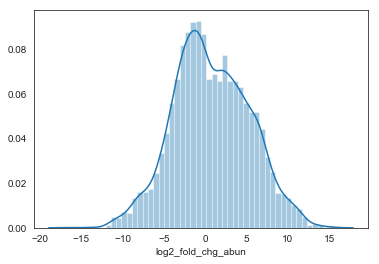

In [14]:
sns.distplot(log_chg_24pass['log2_fold_chg_abun'])

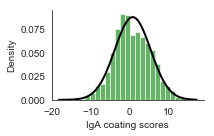

In [24]:
# Generate some data for this demonstration.
data = log_chg_24pass['log2_fold_chg_abun']

# Fit a normal distribution to the data:
mu, std = stats.norm.fit(data)

# Plot the histogram.
fig = plt.figure(figsize = (3,2))

plt.hist(data, bins=25, density=True, alpha=0.6, color='g')

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
#title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.xlabel('IgA coating scores')
plt.ylabel('Density')
#plt.title(title)

sns.despine()
plt.tight_layout()

plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/iga_normal_2019-05-12.png',
            dpi=300)
plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/iga_normal_2019-05-12.pdf',
            dpi=300)

In [23]:
stats.normaltest(data)

NormaltestResult(statistic=37.45530224715516, pvalue=7.35672391476484e-09)

### Expected number of IgA+/– bacteria

In a null world, how many reliably IgA+ and IgA- bacteria do we expect?

We'll look at this without any assumptions by simply shuffling the labels and seeing what comes out.

## IGA labeling in the donor versus the patients

In [9]:
tmp = log_chg[['#OTU ID', 'sample_stool', 'log2_fold_chg_abun']].drop_duplicates()
tmp.head()

,#OTU ID,sample_stool,log2_fold_chg_abun
0,33518e48b174ac428cb7be1a216c6c6e,0044-0025,-1.864271
2,c67445ed68d61f49e41b7bdd1de019fb,0044-0025,-4.645793
4,6afbda63b0750231cd586b402d745cd8,0044-0025,5.663683
6,0243b68c76049aa1b8c51a20333da950,0044-0025,2.864919
8,b621d4b3cca1ec89ceca12efca8a94fb,0044-0025,-1.071944


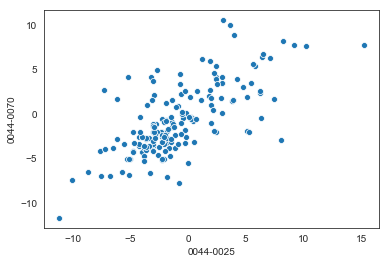

In [12]:
tmp_ftab = tmp.pivot(index='#OTU ID', columns='sample_stool', values='log2_fold_chg_abun')

sns.scatterplot(x=tmp_ftab['0044-0025'], y=tmp_ftab['0044-0070'], data=tmp_ftab)

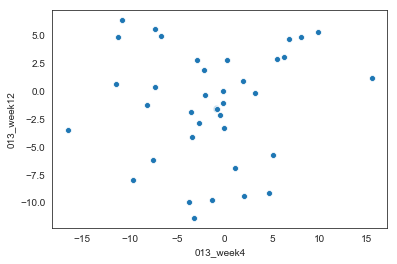

In [15]:
tmp_ftab = tmp.pivot(index='#OTU ID', columns='sample_stool', values='log2_fold_chg_abun')

sns.scatterplot(x=tmp_ftab['013_week4'], y=tmp_ftab['013_week12'], data=tmp_ftab)

In [11]:
tmp_ftab.head()

sample_stool,0044-0025,0044-0070,007_screen,007_week12,007_week18,007_week4,008_screen,008_week12,008_week18,008_week4,...,013_week12,013_week18,013_week4,014_screen,014_week12,014_week18,014_week4,CONTROL_01,CONTROL_02,CONTROL_03
#OTU ID,,,,,,,,,,,,,,,,,,,,,
000db46fcff4701589d112bc2a6044de,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
003e253932cf83d92de80661474011ca,NaN,NaN,NaN,NaN,NaN,NaN,-4.174099,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00a96fbd0ac34bfd245f9c24f8737f7d,-1.144892,-3.797732,-0.094199,-1.406098,-0.555577,1.590206,-4.166850,-1.460204,4.013058,-3.928265,...,NaN,NaN,-7.314306,NaN,-0.215284,-3.812483,-4.220837,9.445839,-6.141688,11.57933
019245104ed4e1a751a760748c8a5205,NaN,NaN,NaN,2.526426,NaN,NaN,NaN,4.186830,NaN,NaN,...,NaN,NaN,4.984043,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0229832aa7a90e786072763d4a7b7207,3.279019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-7.33003,NaN,0.707554,NaN,NaN,NaN,NaN,NaN,NaN


In [166]:
md['approx_wk'].unique()

array([-1.,  4., 12., 18.,  2., nan])

In [167]:
#get mean log-fold change for each otu in each patient
mean_chg_ppat = log_chg.merge(md).groupby(['#OTU ID', 
                                           'patient'])['log2_fold_chg_abun'].mean()
mean_chg_ppat = mean_chg_ppat.reset_index()

#get mean log-fold change only before or after fmt
tmp = log_chg.merge(md)
tmp = tmp.loc[(tmp['days_past_fmt'] > 0) | (tmp['patient'] == '0044')]
tmp = tmp.groupby(['#OTU ID', 'patient'])['log2_fold_chg_abun'].mean()
mean_chg_ppat_pfmt = tmp.reset_index()

tmp = log_chg.merge(md)
tmp = tmp.loc[(tmp['days_past_fmt'] < 0) | (tmp['patient'] == '0044')]
tmp = tmp.groupby(['#OTU ID', 'patient'])['log2_fold_chg_abun'].mean()
mean_chg_ppat_bl = tmp.reset_index()

tmp = log_chg.merge(md)
tmp = tmp.loc[(tmp['approx_wk'] == 4) | (tmp['patient'] == '0044')]
tmp = tmp.groupby(['#OTU ID', 'patient'])['log2_fold_chg_abun'].mean()
mean_chg_ppat_wk4 = tmp.reset_index()

#get only ones that overlap with the donor
donor_0044_otus = mean_chg_ppat.loc[mean_chg_ppat['patient'] == '0044']['#OTU ID'].unique()
mean_chg_ppat_d44 = mean_chg_ppat.loc[mean_chg_ppat['#OTU ID'].isin(donor_0044_otus)]

#for each otu, get the lg chg in donor, mean across pat, mean across placebo, mean across fmt
#mean across d44 fmt
placebo = ['009', '012', '013']
fmt = ['007', '008', '010', '011', '014']
fmt_44 = ['007', '010', '014']
iga_d44_res = []
for otu, sub_df in mean_chg_ppat_d44.groupby('#OTU ID'):
    d44 = sub_df.loc[sub_df['patient'] == '0044']['log2_fold_chg_abun'].mean()
    all_mean = sub_df.loc[sub_df['patient'] != '0044']['log2_fold_chg_abun'].mean()
    placebo_mean = sub_df.loc[sub_df['patient'].isin(placebo)]['log2_fold_chg_abun'].mean()
    fmt_mean = sub_df.loc[sub_df['patient'].isin(fmt)]['log2_fold_chg_abun'].mean()
    fmt44_mean = sub_df.loc[sub_df['patient'].isin(fmt_44)]['log2_fold_chg_abun'].mean()
    iga_d44_res.append([d44, all_mean, placebo_mean, fmt_mean, fmt44_mean])

iga_d44_df = pd.DataFrame(iga_d44_res, columns=['donor_44', 'all_mean', 'placebo_mean', 
                                                'fmt_mean', 'fmt44_mean'])

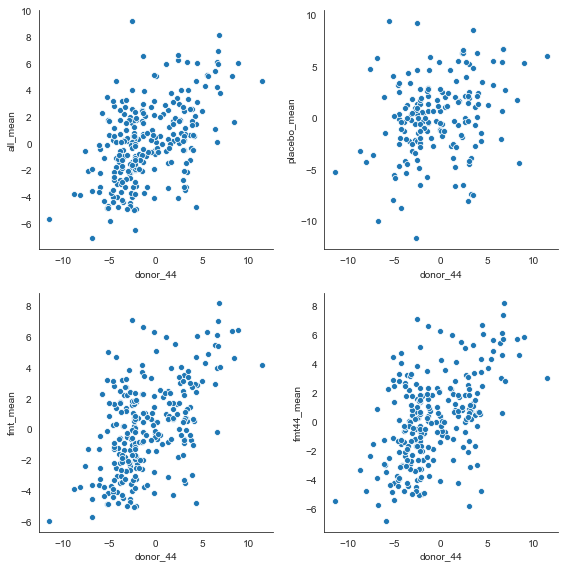

In [163]:
fig = plt.figure(figsize = (8,8))

ax1 = fig.add_subplot(2,2,1)
sns.scatterplot(x='donor_44', y='all_mean', data=iga_d44_df)

ax1 = fig.add_subplot(2,2,2)
sns.scatterplot(x='donor_44', y='placebo_mean', data=iga_d44_df)

ax1 = fig.add_subplot(2,2,3)
sns.scatterplot(x='donor_44', y='fmt_mean', data=iga_d44_df)

ax1 = fig.add_subplot(2,2,4)
sns.scatterplot(x='donor_44', y='fmt44_mean', data=iga_d44_df)

sns.despine()
plt.tight_layout()

In [143]:
for col in ['all_mean', 'placebo_mean', 
            'fmt_mean', 'fmt44_mean']:
    tmp = iga_d44_df.loc[iga_d44_df[col].notnull()]
    print(col, stats.spearmanr(tmp['donor_44'], tmp[col]))

all_mean SpearmanrResult(correlation=0.45704986031767836, pvalue=4.955532582952723e-15)
placebo_mean SpearmanrResult(correlation=0.2540956262231847, pvalue=0.0006909509647659538)
fmt_mean SpearmanrResult(correlation=0.4723990249362451, pvalue=1.0850625207683344e-15)
fmt44_mean SpearmanrResult(correlation=0.4693050855937459, pvalue=2.5707908176671793e-15)


IGA correlations are better correlated across donor and FMT patients than with placebo. However this surprisingly doesn't seem to be generated by the FMT procedure. Effectively, this signal is driven by the fact that at baseline, donor 007 and 008 had iga profiles and labeling very similar to the donor. This is interesting, given that these patients were also responders.

### Across all patient comparisons, what is the correlation of IGA labelling?

In [150]:
pats = sorted(mean_chg_ppat['patient'].unique())
pat_combs = itertools.combinations(pats, 2)

iga_corr = pd.DataFrame(columns=pats, index=pats)
for x, y in pat_combs:
    tmp_x = mean_chg_ppat.loc[mean_chg_ppat['patient'] == x]
    tmp_y = mean_chg_ppat.loc[mean_chg_ppat['patient'] == y]
    
    tmp_merge = tmp_x.merge(tmp_y, on='#OTU ID')
    
    corr = stats.spearmanr(tmp_merge['log2_fold_chg_abun_x'], 
                           tmp_merge['log2_fold_chg_abun_y'])
    
    iga_corr.loc[x, y] = corr[0]
    iga_corr.loc[y, x] = corr[0]

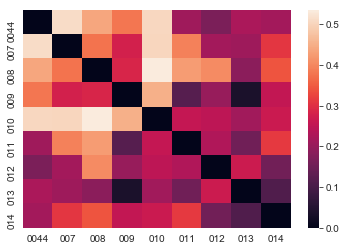

In [153]:
sns.heatmap(iga_corr.fillna(0))

In [197]:
iga_corr

,0044,007,008,009,010,011,012,013,014
0044,NaN,0.51343,0.438888,0.381261,0.506756,0.211239,0.167334,0.226449,0.216729
007,0.51343,NaN,0.376471,0.279274,0.504463,0.394225,0.216161,0.210481,0.310605
008,0.438888,0.376471,NaN,0.287927,0.5347,0.427628,0.405342,0.186239,0.343805
009,0.381261,0.279274,0.287927,NaN,0.45192,0.12075,0.202227,0.0378029,0.254949
010,0.506756,0.504463,0.5347,0.45192,NaN,0.257485,0.250564,0.214221,0.26638
011,0.211239,0.394225,0.427628,0.12075,0.257485,NaN,0.232007,0.153404,0.314745
012,0.167334,0.216161,0.405342,0.202227,0.250564,0.232007,NaN,0.269043,0.155668
013,0.226449,0.210481,0.186239,0.0378029,0.214221,0.153404,0.269043,NaN,0.111648
014,0.216729,0.310605,0.343805,0.254949,0.26638,0.314745,0.155668,0.111648,NaN


### What if you break down into correlations before and after FMT?

In [157]:
pats = sorted(mean_chg_ppat_pfmt['patient'].unique())
pat_combs = itertools.combinations(pats, 2)

iga_corr_pfmt = pd.DataFrame(columns=pats, index=pats)
for x, y in pat_combs:
    tmp_x = mean_chg_ppat_pfmt.loc[mean_chg_ppat_pfmt['patient'] == x]
    tmp_y = mean_chg_ppat_pfmt.loc[mean_chg_ppat_pfmt['patient'] == y]
    
    tmp_merge = tmp_x.merge(tmp_y, on='#OTU ID')
    
    corr = stats.spearmanr(tmp_merge['log2_fold_chg_abun_x'], 
                           tmp_merge['log2_fold_chg_abun_y'])
    
    iga_corr_pfmt.loc[x, y] = corr[0]
    iga_corr_pfmt.loc[y, x] = corr[0]

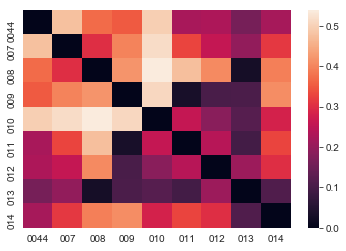

In [158]:
sns.heatmap(iga_corr_pfmt.fillna(0))

In [159]:
pats = sorted(mean_chg_ppat_bl['patient'].unique())
pat_combs = itertools.combinations(pats, 2)

iga_corr_bl = pd.DataFrame(columns=pats, index=pats)
for x, y in pat_combs:
    tmp_x = mean_chg_ppat_bl.loc[mean_chg_ppat_bl['patient'] == x]
    tmp_y = mean_chg_ppat_bl.loc[mean_chg_ppat_bl['patient'] == y]
    
    tmp_merge = tmp_x.merge(tmp_y, on='#OTU ID')
    
    corr = stats.spearmanr(tmp_merge['log2_fold_chg_abun_x'], 
                           tmp_merge['log2_fold_chg_abun_y'])
    
    iga_corr_bl.loc[x, y] = corr[0]
    iga_corr_bl.loc[y, x] = corr[0]

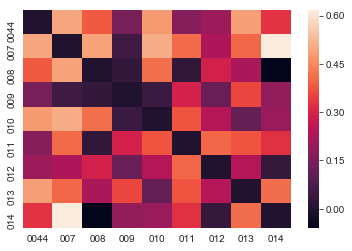

In [160]:
sns.heatmap(iga_corr_bl.fillna(0))

In [161]:
iga_corr_bl

,0044,007,008,009,010,011,012,013,014
0044,NaN,0.497006,0.382964,0.146086,0.474956,0.167878,0.203468,0.483987,0.327622
007,0.497006,NaN,0.490217,0.0527335,0.50657,0.4052,0.228937,0.401357,0.616215
008,0.382964,0.490217,NaN,0.0310453,0.412072,0.0287597,0.292557,0.224954,-0.0592515
009,0.146086,0.0527335,0.0310453,NaN,0.0452154,0.294558,0.123725,0.356654,0.188812
010,0.474956,0.50657,0.412072,0.0452154,NaN,0.373775,0.243267,0.115046,0.199422
011,0.167878,0.4052,0.0287597,0.294558,0.373775,NaN,0.401814,0.375395,0.32539
012,0.203468,0.228937,0.292557,0.123725,0.243267,0.401814,NaN,0.240323,0.0336239
013,0.483987,0.401357,0.224954,0.356654,0.115046,0.375395,0.240323,NaN,0.408149
014,0.327622,0.616215,-0.0592515,0.188812,0.199422,0.32539,0.0336239,0.408149,NaN


In [162]:
iga_corr_pfmt

,0044,007,008,009,010,011,012,013,014
0044,NaN,0.477418,0.370033,0.351995,0.496131,0.22288,0.230304,0.163514,0.222221
007,0.477418,NaN,0.301977,0.39757,0.515716,0.329587,0.259869,0.197075,0.314828
008,0.370033,0.301977,NaN,0.418857,0.537858,0.476653,0.406047,0.0305211,0.393199
009,0.351995,0.39757,0.418857,NaN,0.508945,0.034353,0.103856,0.105895,0.409703
010,0.496131,0.515716,0.537858,0.508945,NaN,0.259165,0.186887,0.120957,0.283503
011,0.22288,0.329587,0.476653,0.034353,0.259165,NaN,0.243701,0.0949401,0.328327
012,0.230304,0.259869,0.406047,0.103856,0.186887,0.243701,NaN,0.20807,0.302365
013,0.163514,0.197075,0.0305211,0.105895,0.120957,0.0949401,0.20807,NaN,0.112959
014,0.222221,0.314828,0.393199,0.409703,0.283503,0.328327,0.302365,0.112959,NaN


In [168]:
pats = sorted(mean_chg_ppat_wk4['patient'].unique())
pat_combs = itertools.combinations(pats, 2)

iga_corr_wk4 = pd.DataFrame(columns=pats, index=pats)
for x, y in pat_combs:
    tmp_x = mean_chg_ppat_wk4.loc[mean_chg_ppat_wk4['patient'] == x]
    tmp_y = mean_chg_ppat_wk4.loc[mean_chg_ppat_wk4['patient'] == y]
    
    tmp_merge = tmp_x.merge(tmp_y, on='#OTU ID')
    
    corr = stats.spearmanr(tmp_merge['log2_fold_chg_abun_x'], 
                           tmp_merge['log2_fold_chg_abun_y'])
    
    iga_corr_wk4.loc[x, y] = corr[0]
    iga_corr_wk4.loc[y, x] = corr[0]

In [169]:
iga_corr_wk4

,0044,007,008,009,010,011,012,013,014
0044,NaN,0.496291,0.426348,0.0578228,0.573142,0.14229,0.303034,0.350856,0.253572
007,0.496291,NaN,0.261338,0.29751,0.451099,0.224494,0.403296,0.309506,0.15321
008,0.426348,0.261338,NaN,0.478068,0.555459,0.402308,0.17392,-0.143286,0.361844
009,0.0578228,0.29751,0.478068,NaN,0.0912734,0.117398,0.186827,-0.177376,0.273433
010,0.573142,0.451099,0.555459,0.0912734,NaN,0.2716,0.300157,0.257241,0.389164
011,0.14229,0.224494,0.402308,0.117398,0.2716,NaN,0.350295,0.161864,0.259823
012,0.303034,0.403296,0.17392,0.186827,0.300157,0.350295,NaN,0.390834,0.0359421
013,0.350856,0.309506,-0.143286,-0.177376,0.257241,0.161864,0.390834,NaN,0.222083
014,0.253572,0.15321,0.361844,0.273433,0.389164,0.259823,0.0359421,0.222083,NaN


### What if we set a minimum threshold abundance to reduce noise?

In [174]:
log_chg_0001 = log_chg.loc[log_chg['rel_abun'] > 0.0001]

#get mean log-fold change for each otu in each patient
mean_chg_ppat = log_chg_0001.merge(md).groupby(['#OTU ID', 
                                           'patient'])['log2_fold_chg_abun'].mean()
mean_chg_ppat = mean_chg_ppat.reset_index()

#get mean log-fold change only before or after fmt
tmp = log_chg_0001.merge(md)
tmp = tmp.loc[(tmp['days_past_fmt'] > 0) | (tmp['patient'] == '0044')]
tmp = tmp.groupby(['#OTU ID', 'patient'])['log2_fold_chg_abun'].mean()
mean_chg_ppat_pfmt = tmp.reset_index()

tmp = log_chg_0001.merge(md)
tmp = tmp.loc[(tmp['days_past_fmt'] < 0) | (tmp['patient'] == '0044')]
tmp = tmp.groupby(['#OTU ID', 'patient'])['log2_fold_chg_abun'].mean()
mean_chg_ppat_bl = tmp.reset_index()

tmp = log_chg_0001.merge(md)
tmp = tmp.loc[(tmp['approx_wk'] == 4) | (tmp['patient'] == '0044')]
tmp = tmp.groupby(['#OTU ID', 'patient'])['log2_fold_chg_abun'].mean()
mean_chg_ppat_wk4 = tmp.reset_index()

#get only ones that overlap with the donor
donor_0044_otus = mean_chg_ppat.loc[mean_chg_ppat['patient'] == '0044']['#OTU ID'].unique()
mean_chg_ppat_d44 = mean_chg_ppat.loc[mean_chg_ppat['#OTU ID'].isin(donor_0044_otus)]

#for each otu, get the lg chg in donor, mean across pat, mean across placebo, mean across fmt
#mean across d44 fmt
placebo = ['009', '012', '013']
fmt = ['007', '008', '010', '011', '014']
fmt_44 = ['007', '010', '014']
iga_d44_res = []
for otu, sub_df in mean_chg_ppat_d44.groupby('#OTU ID'):
    d44 = sub_df.loc[sub_df['patient'] == '0044']['log2_fold_chg_abun'].mean()
    all_mean = sub_df.loc[sub_df['patient'] != '0044']['log2_fold_chg_abun'].mean()
    placebo_mean = sub_df.loc[sub_df['patient'].isin(placebo)]['log2_fold_chg_abun'].mean()
    fmt_mean = sub_df.loc[sub_df['patient'].isin(fmt)]['log2_fold_chg_abun'].mean()
    fmt44_mean = sub_df.loc[sub_df['patient'].isin(fmt_44)]['log2_fold_chg_abun'].mean()
    iga_d44_res.append([d44, all_mean, placebo_mean, fmt_mean, fmt44_mean])

iga_d44_df = pd.DataFrame(iga_d44_res, columns=['donor_44', 'all_mean', 'placebo_mean', 
                                                'fmt_mean', 'fmt44_mean'])

In [175]:
pats = sorted(mean_chg_ppat_bl['patient'].unique())
pat_combs = itertools.combinations(pats, 2)

iga_corr_bl = pd.DataFrame(columns=pats, index=pats)
for x, y in pat_combs:
    tmp_x = mean_chg_ppat_bl.loc[mean_chg_ppat_bl['patient'] == x]
    tmp_y = mean_chg_ppat_bl.loc[mean_chg_ppat_bl['patient'] == y]
    
    tmp_merge = tmp_x.merge(tmp_y, on='#OTU ID')
    
    corr = stats.spearmanr(tmp_merge['log2_fold_chg_abun_x'], 
                           tmp_merge['log2_fold_chg_abun_y'])
    
    iga_corr_bl.loc[x, y] = corr[0]
    iga_corr_bl.loc[y, x] = corr[0]

In [176]:
iga_corr_bl

,0044,007,008,009,010,011,012,013,014
0044,NaN,0.618482,0.549384,0.204946,0.473769,0.249809,0.2285,0.369512,0.273836
007,0.618482,NaN,0.479447,-0.0775401,0.553061,0.520751,0.35419,0.448211,0.518215
008,0.549384,0.479447,NaN,0.0611644,0.425665,0.177419,0.251045,0.308271,0.00201589
009,0.204946,-0.0775401,0.0611644,NaN,0.00635944,0.33639,0.157381,0.36095,0.0671003
010,0.473769,0.553061,0.425665,0.00635944,NaN,0.516449,0.290104,0.265906,0.1372
011,0.249809,0.520751,0.177419,0.33639,0.516449,NaN,0.511425,0.486207,0.260305
012,0.2285,0.35419,0.251045,0.157381,0.290104,0.511425,NaN,0.342344,0.0562606
013,0.369512,0.448211,0.308271,0.36095,0.265906,0.486207,0.342344,NaN,0.382142
014,0.273836,0.518215,0.00201589,0.0671003,0.1372,0.260305,0.0562606,0.382142,NaN


In [177]:
pats = sorted(mean_chg_ppat_pfmt['patient'].unique())
pat_combs = itertools.combinations(pats, 2)

iga_corr_pfmt = pd.DataFrame(columns=pats, index=pats)
for x, y in pat_combs:
    tmp_x = mean_chg_ppat_pfmt.loc[mean_chg_ppat_pfmt['patient'] == x]
    tmp_y = mean_chg_ppat_pfmt.loc[mean_chg_ppat_pfmt['patient'] == y]
    
    tmp_merge = tmp_x.merge(tmp_y, on='#OTU ID')
    
    corr = stats.spearmanr(tmp_merge['log2_fold_chg_abun_x'], 
                           tmp_merge['log2_fold_chg_abun_y'])
    
    iga_corr_pfmt.loc[x, y] = corr[0]
    iga_corr_pfmt.loc[y, x] = corr[0]

In [178]:
iga_corr_pfmt

,0044,007,008,009,010,011,012,013,014
0044,NaN,0.512505,0.408794,0.436573,0.54296,0.319544,0.449966,0.292508,0.337281
007,0.512505,NaN,0.461668,0.392137,0.522992,0.373676,0.404628,0.131385,0.420639
008,0.408794,0.461668,NaN,0.556833,0.636254,0.488723,0.495398,0.0728913,0.550107
009,0.436573,0.392137,0.556833,NaN,0.589646,0.103686,0.182962,0.103208,0.458173
010,0.54296,0.522992,0.636254,0.589646,NaN,0.291992,0.265479,0.110682,0.262839
011,0.319544,0.373676,0.488723,0.103686,0.291992,NaN,0.413882,0.157233,0.467377
012,0.449966,0.404628,0.495398,0.182962,0.265479,0.413882,NaN,0.251944,0.455601
013,0.292508,0.131385,0.0728913,0.103208,0.110682,0.157233,0.251944,NaN,0.128813
014,0.337281,0.420639,0.550107,0.458173,0.262839,0.467377,0.455601,0.128813,NaN


In [179]:
pats = sorted(mean_chg_ppat_wk4['patient'].unique())
pat_combs = itertools.combinations(pats, 2)

iga_corr_wk4 = pd.DataFrame(columns=pats, index=pats)
for x, y in pat_combs:
    tmp_x = mean_chg_ppat_wk4.loc[mean_chg_ppat_wk4['patient'] == x]
    tmp_y = mean_chg_ppat_wk4.loc[mean_chg_ppat_wk4['patient'] == y]
    
    tmp_merge = tmp_x.merge(tmp_y, on='#OTU ID')
    
    corr = stats.spearmanr(tmp_merge['log2_fold_chg_abun_x'], 
                           tmp_merge['log2_fold_chg_abun_y'])
    
    iga_corr_wk4.loc[x, y] = corr[0]
    iga_corr_wk4.loc[y, x] = corr[0]

In [199]:
log_chg.head()

,#OTU ID,sample_iga_stool,count,gate,sample_stool,count_psct,rel_abun_psct,rel_abun,log2_abun,log2_fold_chg_abun,rel_abun_mean,rel_abun_max
0,33518e48b174ac428cb7be1a216c6c6e,0044-0025_pos,20.0,pos,0044-0025,20.5,0.000271,0.000265,-11.847955,-1.864271,0.000624,0.000983
1,33518e48b174ac428cb7be1a216c6c6e,0044-0025_neg,80.0,neg,0044-0025,80.5,0.000988,0.000983,-9.983684,-1.864271,0.000624,0.000983
2,c67445ed68d61f49e41b7bdd1de019fb,0044-0025_pos,1.0,pos,0044-0025,1.5,0.000020,0.000013,-15.620544,-4.645793,0.000252,0.000491
3,c67445ed68d61f49e41b7bdd1de019fb,0044-0025_neg,40.0,neg,0044-0025,40.5,0.000497,0.000491,-10.974751,-4.645793,0.000252,0.000491
4,6afbda63b0750231cd586b402d745cd8,0044-0025_pos,23.0,pos,0044-0025,23.5,0.000311,0.000305,-11.650918,5.663683,0.000152,0.000305


## Do engrafted OTUs maintain similar IGA labeling?

In [247]:
d44_pats = ['007', '010', '014']

log_chg_eng = log_chg.merge(md)
log_chg_eng = log_chg_eng.loc[log_chg_eng['patient'].isin(d44_pats + ['0044'])]

d44_otus = set(log_chg_eng.loc[log_chg_eng['patient'] == '0044']['#OTU ID'])

eng_otus_res = []
shr_otus_res = []
for patient, sub_df in log_chg_eng.groupby('patient'):
    if patient == '0044':
        continue
    
    bl_otus = set(sub_df.loc[sub_df['days_past_fmt'] < 0]['#OTU ID'])
    pfmt_otus = set(sub_df.loc[sub_df['days_past_fmt'] > 0]['#OTU ID'])
    eng_otus = (pfmt_otus & d44_otus) - bl_otus
    out_df = sub_df.loc[sub_df['#OTU ID'].isin(eng_otus)]
    out_df.loc[:, 'patient'] = patient
    out_df = out_df[['#OTU ID', 'sample_stool', 'patient',
                     'rel_abun_mean', 'log2_fold_chg_abun']].drop_duplicates()
    
    eng_otus_res.append(out_df)
    
    #get shared otus as well
    shr_otus = bl_otus & d44_otus
    out_df = sub_df.loc[sub_df['#OTU ID'].isin(shr_otus)]
    out_df.loc[:, 'patient'] = patient
    out_df = out_df[['#OTU ID', 'sample_stool', 'patient',
                     'rel_abun_mean', 'log2_fold_chg_abun']].drop_duplicates()
    shr_otus_res.append(out_df)

eng_otus_res_df = pd.concat(eng_otus_res)
shr_otus_res_df = pd.concat(shr_otus_res)

/Users/ndchu/programs/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [244]:
mean_chg_ppat = log_chg.merge(md).groupby(['#OTU ID', 
                                           'patient'])['log2_fold_chg_abun'].mean()
mean_chg_ppat = mean_chg_ppat.reset_index()

#get mean 

plt_dfs = []
for patient, sub_df in eng_otus_res_df.groupby('patient'):
    #get mean iga chg per otu
    mean_iga = sub_df.groupby('#OTU ID').mean().reset_index()
    mean_d44 = mean_chg_ppat.loc[mean_chg_ppat['patient'] == '0044']
    plt_df = mean_d44.merge(mean_iga, on='#OTU ID')
    
    #filter for somewhat abundant bugs
    plt_df = plt_df.loc[plt_df['rel_abun_mean'] > 0.0001]
    
    plt_dfs.append(plt_df)

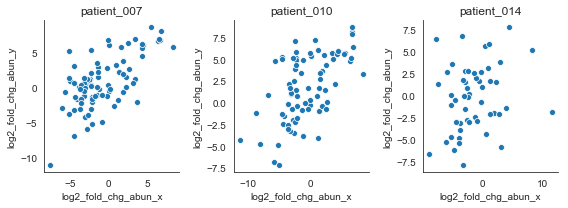

In [245]:
fig = plt.figure(figsize = (8,3))

ax1 = fig.add_subplot(1,3,1)
sns.scatterplot(x='log2_fold_chg_abun_x', 
                y='log2_fold_chg_abun_y', data=plt_dfs[0])
ax1.set_title('patient_007')

ax2 = fig.add_subplot(1,3,2)
sns.scatterplot(x='log2_fold_chg_abun_x', 
                y='log2_fold_chg_abun_y', data=plt_dfs[1])
ax2.set_title('patient_010')

ax3 = fig.add_subplot(1,3,3)
sns.scatterplot(x='log2_fold_chg_abun_x', 
                y='log2_fold_chg_abun_y', data=plt_dfs[2])
ax3.set_title('patient_014')

sns.despine()
plt.tight_layout()

In [246]:
for df in plt_dfs:
    print(stats.spearmanr(df['log2_fold_chg_abun_x'], 
                          df['log2_fold_chg_abun_y']))

SpearmanrResult(correlation=0.5604455735782685, pvalue=2.4370823054980442e-08)
SpearmanrResult(correlation=0.5677432408962008, pvalue=5.9369801022308195e-08)
SpearmanrResult(correlation=0.26052249637155295, pvalue=0.05955343736640035)


So engrafted OTUs do largely retain a similar IGA labeling profile. What if we only look at the OTUs shared with baseline?

In [253]:
shr_otus_res_df.head()

,#OTU ID,sample_stool,patient,rel_abun_mean,log2_fold_chg_abun
880,33518e48b174ac428cb7be1a216c6c6e,007_screen,007,0.004677,-0.323795
881,c67445ed68d61f49e41b7bdd1de019fb,007_screen,007,0.001885,-0.690302
883,5a6c87d6a4eb5e114959f6192f29b641,007_screen,007,0.004029,1.208236
884,80f1349ed470beddcd0936b8385fe20c,007_screen,007,0.001537,-3.121520
888,df14354ec277348c54d0c9dd49eb4da0,007_screen,007,0.001512,-1.760034


In [254]:
plt_shr_dfs = []

for patient, sub_df in shr_otus_res_df.loc[~shr_otus_res_df['sample_stool'].str.endswith('screen')].groupby('patient'):
    #get mean iga chg per otu
    mean_iga = sub_df.groupby('#OTU ID').mean().reset_index()
    mean_d44 = mean_chg_ppat.loc[mean_chg_ppat['patient'] == '0044']
    plt_df = mean_d44.merge(mean_iga, on='#OTU ID')
    
    #filter for somewhat abundant bugs
    plt_df = plt_df.loc[plt_df['rel_abun_mean'] > 0.0001]
    
    plt_shr_dfs.append(plt_df)

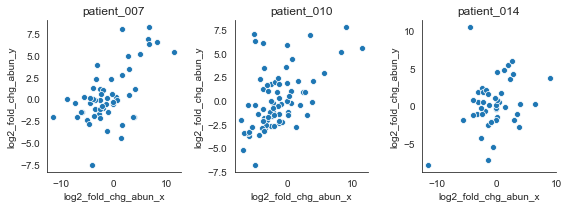

In [255]:
fig = plt.figure(figsize = (8,3))

ax1 = fig.add_subplot(1,3,1)
sns.scatterplot(x='log2_fold_chg_abun_x', 
                y='log2_fold_chg_abun_y', data=plt_shr_dfs[0])
ax1.set_title('patient_007')

ax2 = fig.add_subplot(1,3,2)
sns.scatterplot(x='log2_fold_chg_abun_x', 
                y='log2_fold_chg_abun_y', data=plt_shr_dfs[1])
ax2.set_title('patient_010')

ax3 = fig.add_subplot(1,3,3)
sns.scatterplot(x='log2_fold_chg_abun_x', 
                y='log2_fold_chg_abun_y', data=plt_shr_dfs[2])
ax3.set_title('patient_014')

sns.despine()
plt.tight_layout()

In [256]:
for df in plt_shr_dfs:
    print(stats.spearmanr(df['log2_fold_chg_abun_x'], 
                          df['log2_fold_chg_abun_y']))

SpearmanrResult(correlation=0.4544771018455229, pvalue=0.0004337839842037367)
SpearmanrResult(correlation=0.4717156527682843, pvalue=1.6968953192437352e-05)
SpearmanrResult(correlation=0.21198026779422124, pvalue=0.16715745096035992)


## Tracking ruminococcus gnavus abundances

In [27]:
gnavus_otus = taxa_otu.loc[taxa_otu['genus'].str.contains('gnavus', 
                                                          na=False)]['Feature ID']
#get otu table for only these otus, and sum over them
gnavus_tidy = otu_tidy.loc[otu_tidy['#OTU ID'].isin(gnavus_otus)]

gnavus_sum = gnavus_tidy.groupby('sample_id')[['count', 'rel_abun']].sum()
gnavus_sum = gnavus_sum.reset_index().merge(md_otu)
gnavus_sum.loc[:, 'patient_plt'] = 'patient_' + gnavus_sum['patient']
gnavus_sum.loc[:, 'log_rel_abun'] = np.log10(gnavus_sum['rel_abun']) 

/Users/ndchu/programs/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


In [23]:
gnavus_sum.head()

,sample_id,count,rel_abun,storage,barcode_id,patient_donor,patient,approx_wk,days_past_fmt,treatment,fmt_induction,fmt_current,fmt_past,clinical_intervention,responder_fmt,reads_16s,reads_mgx,sample_mimarks,notes
0,0044-0076,619,0.022648,glycerol,NaN,donor,0044,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,245696.0,49244224.0,0044.0076,NaN
1,0044-0101,764,0.029188,glycerol,NaN,donor,0044,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,225716.0,54580584.0,0044.0101,NaN
2,0044-0103,398,0.016311,glycerol,NaN,donor,0044,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,228144.0,48243444.0,0044.0103,NaN
3,0044-0115,167,0.008618,glycerol,NaN,donor,0044,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,197020.0,34942412.0,0044.0115,NaN
4,0044-0126,376,0.016884,glycerol,NaN,donor,0044,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,189928.0,78593104.0,0044.0126,NaN


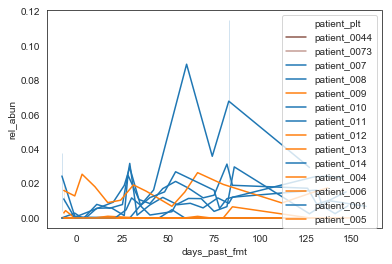

In [34]:
sns.lineplot(x='days_past_fmt', y='rel_abun',
             data=gnavus_sum, hue='patient_plt',
             palette=dd_pat_treat_name
            )